# Pipelines - Missing Values,  Random Forest - Feature Selection


This notebook will go over how to Create a Pipeline to Fill in and transforms numeric and categorical features.
Then will go over how to use Random Forests for feature selection.


### Data


Our training data has 1459 observations and 80 features (numeric and categorical).

We use a copy of the Iowa house prices train/test datasets available on Kaggle

http://jse.amstat.org/v19n3/decock.pdf


In [145]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [114]:
#log-transform the y variable:

#X_train, y_train = train.loc[:, train.columns != 'SalePrice'], np.log(train['SalePrice'])

train = pd.read_csv('C:/Users/uknow/Desktop/train.csv')
test  = pd.read_csv('C:/Users/uknow/Desktop/test.csv')
y_train = np.log(train['SalePrice'])
train.drop('SalePrice', axis=1, inplace=True)

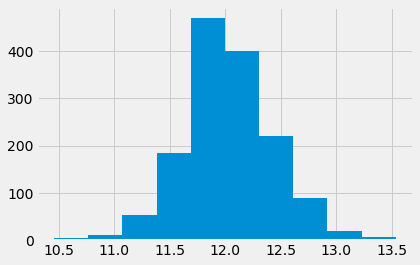

In [115]:
#check normality of the log-transformed y data

y_train.hist();

### Dataset with 80 Features: 

numeric and categorical 

In [116]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object


# Missing values

In [117]:
train.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond

##  Creating a pipeline using "make_pipeline()" to fill in the missing values 

### First separate Numeric and Categorical columns in 2 classes:


In [118]:
numeric_cols = train.select_dtypes(include=np.number).columns.tolist()
cat_cols     = train.select_dtypes(include=np.object).columns.tolist()


### Standardize, Encode 
- Standardize numeric cols using StandardScaler()
- Performing one-hot encoding on nominal features using OneHotEncoder()


###  " SimpleImputer()" 
Use different interpolation techniques to estimate the missing values from the other training samples in our dataset.

Replace the missing value by the median/mode of the entire feature column:

- Median for numeric cols
- Most frequent for categorical cols

In [119]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

## Fit a "ColumnTransformer()" that fills in and transforms numeric and categorical features combined:

In [120]:
transform = [
    ('num', numeric_pipe, numeric_columns),
    ('cat', cat_pipe, cat_columns)
]

pipe = ColumnTransformer(transform)

### Transform train dataset

- We fit the ColumnTransformer only once on the training data and use those parameters to transform the test set or any new data point.

In [121]:
#train_clean

X_train = pipe.fit_transform(train)

### Transform the  test set 

*according to the shape of our training set*.


In [122]:
#test_clean

test  = pipe.transform(test)

# Feature selection


To select relevant features from large datasets one can use a random forest

## Assessing feature importance with Random Forest, an advanced regression technique

Using feature_importances_ attribute to access feature importances after fitting a RandomForestRegressor:

### Build a Random Forest Regression model to the cleaned dataset


In [123]:
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

In [124]:
def rmse(estimator, X, y):
    preds  = estimator.predict(X)
    error = np.sqrt(np.mean((preds - y)**2))
    return error


samples_per_leaf = [1, 5, 10, 15, 25, 50]
rf_scores = []


for num_samples in samples_per_leaf:
    rf.set_params(min_samples_leaf=num_samples)
    scores = cross_val_score(estimator=rf, X=X_train, y=y_train, scoring=rmse, cv=10)
    rf_scores.append((np.mean(scores), num_samples))

In [125]:
rf_scores

[(0.16254482664855371, 1),
 (0.16595201656016761, 5),
 (0.16764607981518884, 10),
 (0.17049766842827999, 15),
 (0.1798958129887907, 25),
 (0.19610564934310834, 50)]

In [126]:
rf.set_params(min_samples_leaf=1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [127]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

#### Access feature importances :

In [130]:
importances = rf.feature_importances_
importances

array([0.01697072, 0.58906117, 0.03117066, 0.07762109, 0.09028938,
       0.01183331, 0.15377583, 0.00692438, 0.00445623, 0.00356124,
       0.014336  ])

In [140]:
indices = np.argsort(importances)[::-1]

In [141]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, train.columns[1:][f], importances[indices[f]]))

 1) MSSubClass                     0.589061
 2) MSZoning                       0.153776
 3) LotFrontage                    0.090289
 4) LotArea                        0.077621
 5) Street                         0.031171
 6) Alley                          0.016971
 7) LotShape                       0.014336
 8) LandContour                    0.011833
 9) Utilities                      0.006924
10) LotConfig                      0.004456
11) LandSlope                      0.003561


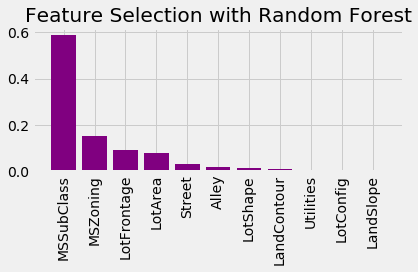

In [146]:
plt.title('Feature Selection with Random Forest')

plt.bar(range(X_train.shape[1]), importances[indices], color='purple', align='center')
plt.xticks(range(X_train.shape[1]), train.columns[1:], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()